In [26]:
import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageEnhance
from itertools import permutations, combinations
import numpy as np
import uuid

In [27]:
from roboflow import Roboflow
rf = Roboflow(api_key="Q0EN6hdjVCdwqJnAAYvc")
project = rf.workspace().project("playing-cards-ow27d")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


In [28]:
path_52cards = "52cards/"
prefix = "800px-Playing_card_"
suffix = ".svg.png"

In [29]:
suits = ["spade", "club", "diamond", "heart"]
cards = ["2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K", "A"]
ranks = {"0_highcard": 0, "0_pair": 1, "1_highcard": 2, "1_pair": 3,
         "2_highcard": 4, "2_pair": 5, "3_highcard": 6, "3_pair": 7,
         "4_highcard": 8, "4_pair": 9, "5_highcard": 10, "5_pair": 11,
         "6_highcard": 12, "6_pair": 13, "7_highcard": 14, "7_pair": 15,
         "8_highcard": 16, "8_pair": 17, "9_highcard": 18, "9_pair": 19,
         "three_of_images": 20, "straight": 21, "three_of_a_kind": 22
        }
all_of_straights = list(permutations(["A", "2", "3"]))
all_of_straights += list(permutations(["2", "3", "4"]))
all_of_straights += list(permutations(["3", "4", "5"]))
all_of_straights += list(permutations(["4", "5", "6"]))
all_of_straights += list(permutations(["5", "6", "7"]))
all_of_straights += list(permutations(["6", "7", "8"]))
all_of_straights += list(permutations(["7", "8", "9"]))
all_of_straights += list(permutations(["8", "9", "10"]))
all_of_straights += list(permutations(["9", "10", "J"]))
all_of_straights += list(permutations(["10", "J", "Q"]))
all_of_straights += list(permutations(["J", "Q", "K"]))
all_of_straights += list(permutations(["Q", "K", "A"]))

def intt(card):
    try:
        num = int(card)
    except:
        if card == "A":
            return 1
        else:
            return 0
    return num % 10


def card_split(suit_card):
    tmp = suit_card.split("_")
    return tmp[0], tmp[1]


def cards_comparison(card_1, card_2):
    s1, c1 = card_split(card_1)
    s2, c2 = card_split(card_2)
    c_in_1, c_in_2 = cards.index(c1), cards.index(c2)
    if c_in_1 > c_in_2:
        return 1
    if c_in_1 < c_in_2:
        return -1
    # c_in_1 == c_in_2:
    s_in_1, s_in_2 = suits.index(s1), suits.index(s2)
    if s_in_1 > s_in_2:
        return 1
    if s_in_1 < s_in_2:
        return -1
    return 0


def four_of_a_kind(hands):
    count_ = dict()
    for card in hands:
        s, c = card_split(card)
        if c not in count_.keys():
            count_[c] = 1
        else:
            count_[c] += 1
    kind = None
    for key, value in count_.items():
        if value == 4:
            if kind == None:
                kind = key
            elif cards.index(key) > cards.index(kind):
                kind = key
    return kind


A23_combo = list(permutations(["A", "2", "3"]))
def identify_combo(combo):
    card_1, card_2, card_3 = combo
    s1, c1 = card_split(card_1)
    s2, c2 = card_split(card_2)
    s3, c3 = card_split(card_3)

    compare_1_2 = cards_comparison(card_1, card_2)
    compare_2_3 = cards_comparison(card_2, card_3)
    compare_3_1 = cards_comparison(card_3, card_1)
    
    if c1 == c2 == c3:
        return "three_of_a_kind", card_1

    if (c1, c2, c3) in all_of_straights:
        if (c1, c2, c3) in A23_combo:
            if c1 == "3":
                return "straight", card_1
            if c2 == "3":
                return "straight", card_2
            if c3 == "3":
                return "straight", card_3

        if compare_1_2 == 1 and compare_3_1 == -1:
            return "straight", card_1
        if compare_2_3 == 1 and compare_1_2 == -1:
            return "straight", card_2
        if compare_3_1 == 1 and compare_2_3 == -1:
            return "straight", card_3
    
    # There's no such thing as "J", "Q" and "K" appearing together
    if c1 in ["J", "Q", "K"] and c2 in ["J", "Q", "K"] and c3 in ["J", "Q", "K"]:
        if c1 == c2:
            if compare_1_2 == 1:
                return "three_of_images", card_1
            else:
                return "three_of_images", card_2
        if c2 == c3:
            if compare_2_3 == 1:
                return "three_of_images", card_2
            else:
                return "three_of_images", card_3
        if c3 == c1:
            if compare_3_1 == 1:
                return "three_of_images", card_3
            else:
                return "three_of_images", card_1
    
    cards_sum = (intt(c1) + intt(c2) + intt(c3)) % 10
    if c1 == c2:
        if compare_1_2 == 1:
            return str(cards_sum) + "_pair", card_1
        else:
            return str(cards_sum) + "_pair", card_2
    if c2 == c3:
        if compare_2_3 == 1:
            return str(cards_sum) + "_pair", card_2
        else:
            return str(cards_sum) + "_pair", card_3
    if c3 == c1:
        if compare_3_1 == 1:
            return str(cards_sum) + "_pair", card_3
        else:
            return str(cards_sum) + "_pair", card_1
    if compare_1_2 == 1 and compare_3_1 == -1:
        return str(cards_sum) + "_highcard", card_1
    if compare_2_3 == 1 and compare_1_2 == -1:
        return str(cards_sum) + "_highcard", card_2
    if compare_3_1 == 1 and compare_2_3 == -1:
        return str(cards_sum) + "_highcard", card_3


def comboes_comparison(combo_1, combo_2):
    identify_1, repr_1 = identify_combo(combo_1)
    identify_2, repr_2 = identify_combo(combo_2)
    i_in_1 = ranks[identify_1]
    i_in_2 = ranks[identify_2]
    if i_in_1 > i_in_2:
        return 1
    if i_in_1 < i_in_2:
        return -1
    # i_in_1 == i_in 2:
    return cards_comparison(repr_1, repr_2)


def hands_comparison(hands_1, hands_2):
    combo_1_1, combo_1_2, combo_1_3 = hands_1
    combo_2_1, combo_2_2, combo_2_3 = hands_2
    value = comboes_comparison(combo_1_1, combo_2_1)
    value += comboes_comparison(combo_1_2, combo_2_2)
    value += comboes_comparison(combo_1_3, combo_2_3)
    return value


def vip_permutations(hands):
    vip_perm = []
    comboes_1 = list(combinations(hands, 3))
    for c0, c1, c2 in comboes_1:
        combo_1 = (c0, c1, c2)
        tmp_hands = hands.copy()
        tmp_hands.remove(c0)
        tmp_hands.remove(c1)
        tmp_hands.remove(c2)
        comboes_2 = list(combinations(tmp_hands, 3))
        for c3, c4, c5 in comboes_2:
            combo_2 = (c3, c4, c5)

            combo_3 = tmp_hands.copy()
            combo_3.remove(c3)
            combo_3.remove(c4)
            combo_3.remove(c5)
            combo_3 = tuple(combo_3)

            if comboes_comparison(combo_1, combo_2) == -1 and comboes_comparison(combo_2, combo_3) == -1:
                vip_hands = [combo_1, combo_2, combo_3]
                vip_perm.append(vip_hands)
    return vip_perm


def n_largest(a):
    b1 = [0] * len(a)
    for i in range(0, len(a)-1):
        for j in range(i+1, len(a)):
            tmp = hands_comparison(a[i], a[j])
            b1[i] += tmp // np.abs(tmp)
            b1[j] -= tmp // np.abs(tmp)
            
    b1 = np.array(b1)
    n_top = 7
    ind = np.argpartition(b1, -n_top)[-n_top:]

    top_10 = b1[ind]
    for i in range(0, n_top-1):
        for j in range(0, n_top-i-1):
            if top_10[j] < top_10[j+1]:
                top_10[j], top_10[j+1] = top_10[j+1], top_10[j]
                ind[j], ind[j+1] = ind[j+1], ind[j]
            if top_10[j] == top_10[j+1]:
                if hands_comparison(a[j], a[j+1]) < 0:
                    top_10[j], top_10[j+1] = top_10[j+1], top_10[j]
                    ind[j], ind[j+1] = ind[j+1], ind[j]

    tmp = [_/(len(a)-1) for _ in top_10]

    return np.array(a)[ind], tmp

In [1]:
from math import comb
comb(9, 3)*comb(6, 3)

1680

In [30]:
test_path = "test/"
results_path = "results/"

def show_hand(hand, result_path):
    fig = plt.figure(figsize=(8, 12))
    columns, rows = 3, 3
    for i in range(3):
        for j in range(3):
            card = hand[i][j]
            card_path = path_52cards + prefix + card + suffix
            img = mpimg.imread(card_path)
            fig.add_subplot(rows, columns, i*3 + j + 1)
            plt.axis("off")
            plt.imshow(img)
    fig.savefig(result_path)
    im = Image.open(result_path)
    plt.axis("off")
    plt.show()
    return im
    

def flip(img):
    uuid_generator = str(uuid.uuid4())
    image_path = test_path + uuid_generator + ".jpg"
    result_path = results_path + uuid_generator + ".jpg"
    
    width, height = img.size
    if width == 0 or height == 0:
        return img
    if height > 800:
        width = width * 800 // height
        height = 800
        img = img.resize((width, height))
    
#     enhancer = ImageEnhance.Brightness(img)
#     factor = 1.0
#     img = enhancer.enhance(factor)
    
    img_save = img.save(image_path)
    infer_on_a_local_image = model.predict(image_path, confidence=50, overlap=50).json()
    
    predictions = infer_on_a_local_image["predictions"]
    
    preds = sorted(predictions, key=lambda d: d['confidence'], reverse=True)
    
    classes = []
    for ele in preds:
        print(ele["class"], ele["confidence"])
        if ele["class"] not in classes:
            classes.append(ele["class"])
        if len(classes) == 9:
            break
    if len(classes) < 9:
        return img
    
    hands = []
    for cl in classes:
        card = cl[:-1]
        if cl[-1] == "S":
            card = "spade_" + card
        elif cl[-1] == "C":
            card = "club_" + card
        elif cl[-1] == "D":
            card = "diamond_" + card
        elif cl[-1] == "H":
            card = "heart_" + card
        hands.append(card)

    
    kind = four_of_a_kind(hands)
    if kind:
        fig = plt.figure(figsize=(12, 3))
        four = [_ + "_" + kind for _ in suits]
        for i, card in enumerate(four):
            card_path = path_52cards + prefix + card + suffix
            img = mpimg.imread(card_path)
            fig.add_subplot(1, 4, i+1)
            plt.axis("off")
            plt.imshow(img)
        fig.savefig(result_path)
        im = Image.open(result_path)
        plt.axis("off")
        plt.show()
        return im
    
    all_hands = vip_permutations(hands)
    n_lar, scores = n_largest(all_hands)
    try:
        for hand, score in zip(n_lar, scores):
            im = show_hand(hand, result_path)
            break
    except Exception as e:
        print(e)
        im = img
    return im

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
`optional` parameter is deprecated, and it has no effect


Running on local URL:  http://127.0.0.1:7865
Running on public URL: https://0567e493-f7c6-46d0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


8C 0.9135164022445679
9C 0.9048936367034912
QH 0.8982887268066406
AH 0.8956577777862549
10H 0.8884295225143433
3S 0.8845789432525635
4H 0.88231360912323
KD 0.8764510154724121
5H 0.8709093332290649


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


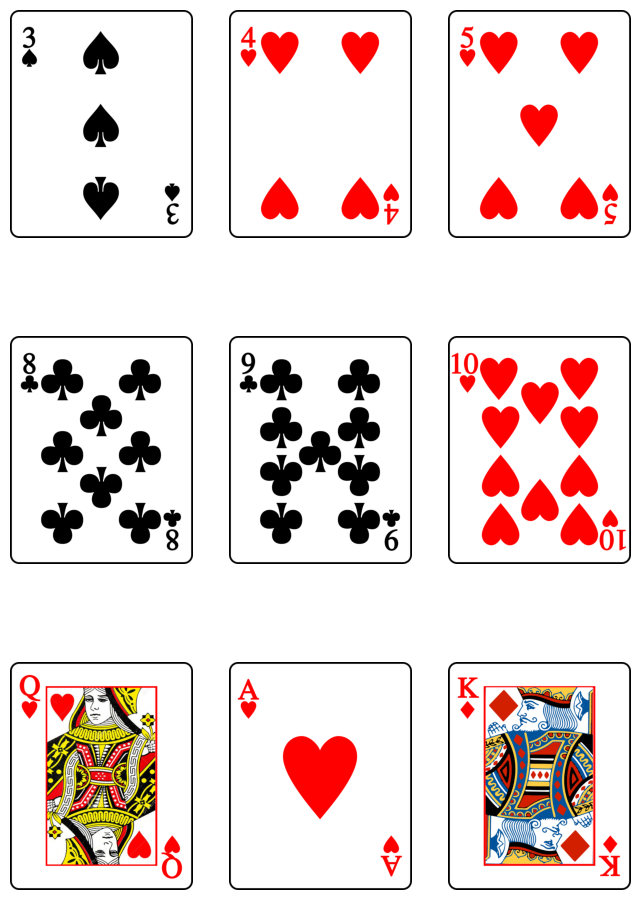

2C 0.9381202459335327
10H 0.9312261343002319
4D 0.9294995069503784
8S 0.9235638380050659
7H 0.9067155122756958
2H 0.9027321338653564
6C 0.9010354280471802
3H 0.8992260694503784
AS 0.8620704412460327


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


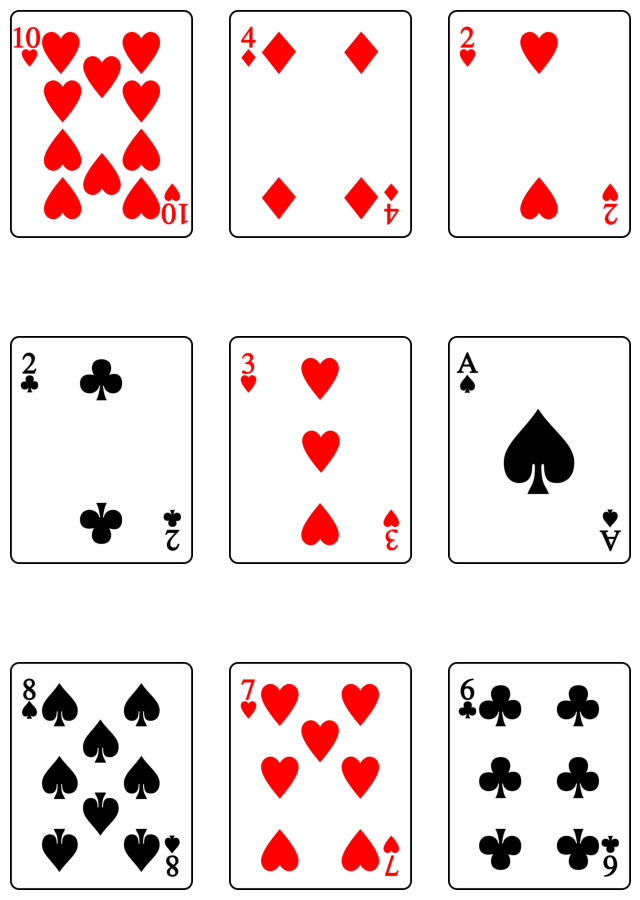

2S 0.940824031829834
4C 0.9352302551269531
10D 0.9306411147117615
3D 0.9213413000106812
3C 0.9128938913345337
9H 0.9069627523422241
QD 0.9054064750671387
5S 0.903976559638977
7C 0.8940390348434448


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


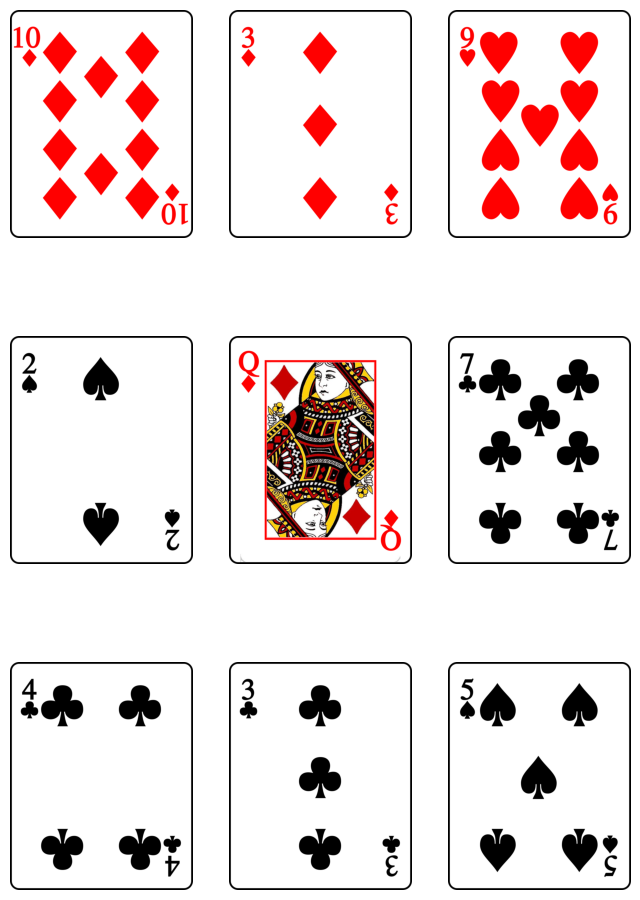

9H 0.9442613124847412
9C 0.9289578199386597
3C 0.924866259098053
2D 0.9166211485862732
9S 0.915278971195221
QD 0.9143344163894653
3S 0.9140669703483582
5S 0.9102821350097656
4C 0.90372633934021


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


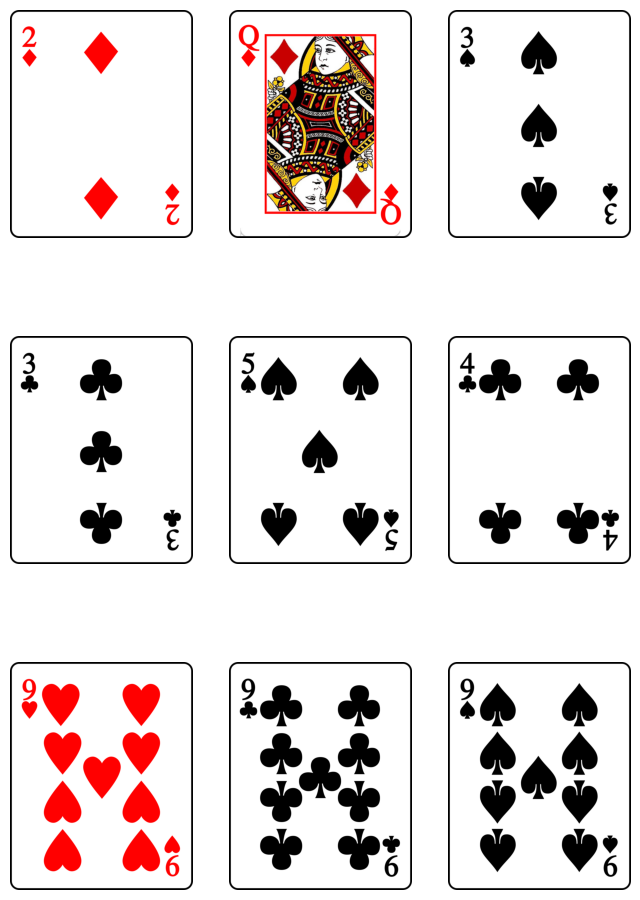

4H 0.9282986521720886
4D 0.9276557564735413
KH 0.9256886839866638
7D 0.924946665763855
9D 0.9183275699615479
KD 0.9176971912384033
KS 0.9133855104446411
5S 0.9012963771820068
QH 0.8961493372917175


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


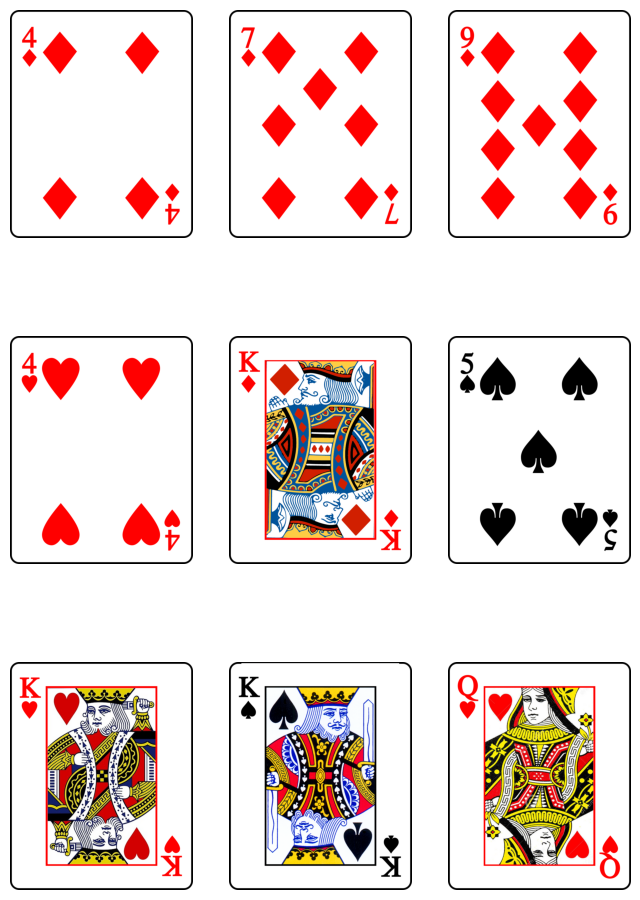

5H 0.9415751695632935
7D 0.938448429107666
10D 0.9323405027389526
5S 0.9309648871421814
7C 0.9272674322128296
4S 0.918907880783081
4H 0.913382887840271
KH 0.9006942510604858
KH 0.8796685934066772
AH 0.8693852424621582


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


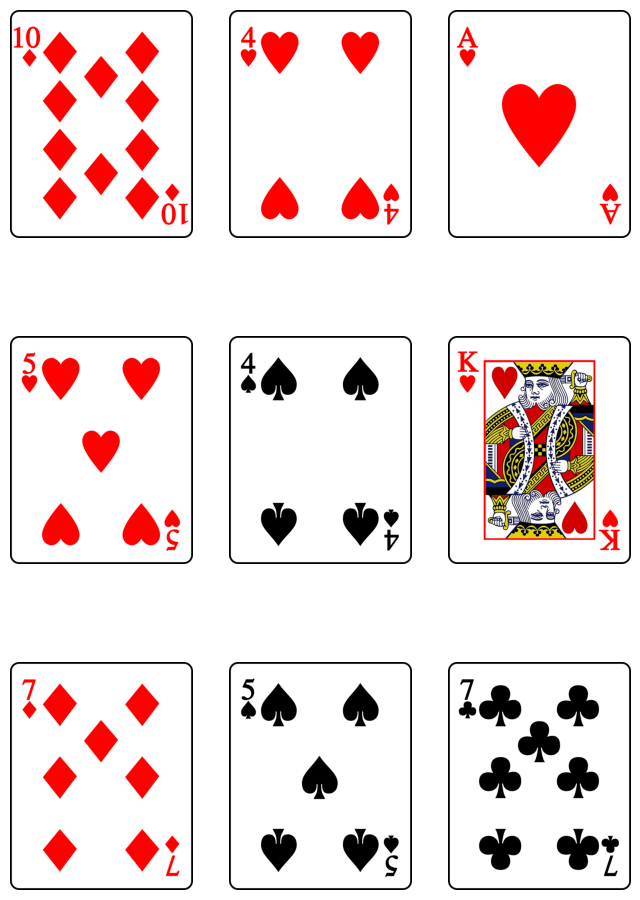

6D 0.9449360966682434
9C 0.9417699575424194
10C 0.9378891587257385
AD 0.9341193437576294
8D 0.9304372072219849
JS 0.9228610992431641
5D 0.9055010080337524
KC 0.9013440608978271
QS 0.7959334850311279


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


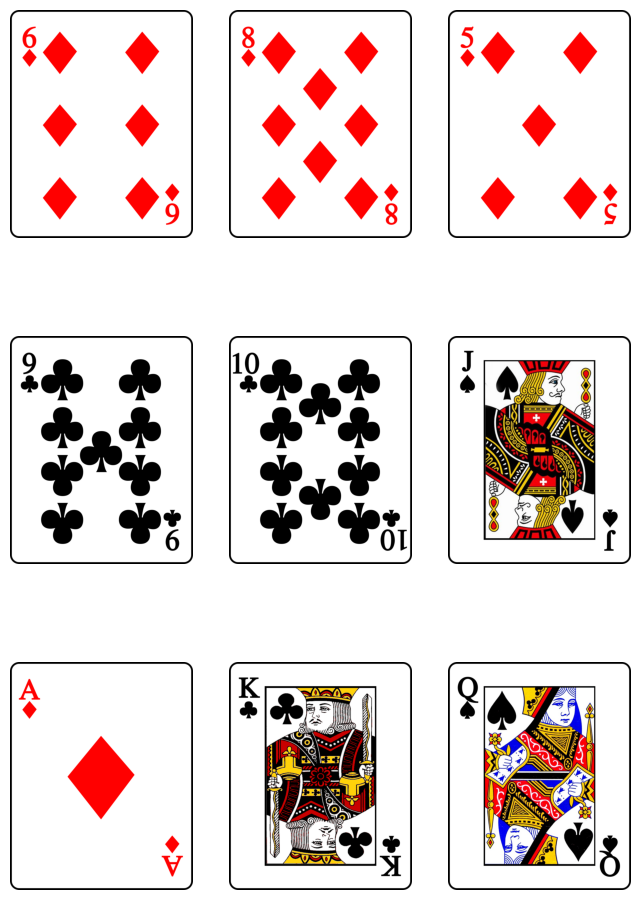

6H 0.9426641464233398
5S 0.9348289370536804
9D 0.9212942123413086
3H 0.9192925095558167
7S 0.9168248176574707
9D 0.9165235161781311
AH 0.9161275625228882
4D 0.9114761352539062
7H 0.9089483022689819
JD 0.9010236263275146


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


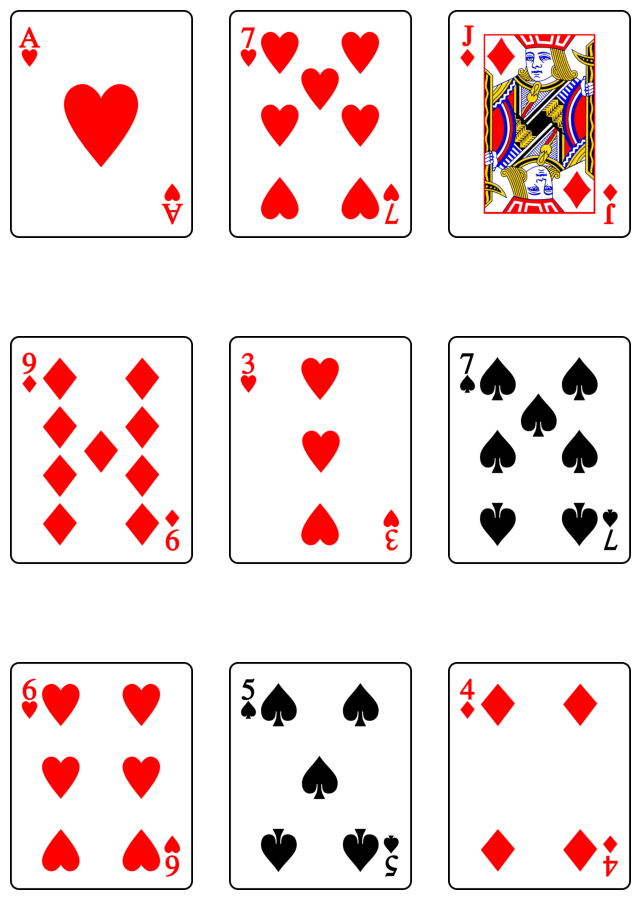

9D 0.9423801898956299
7C 0.9355303049087524
4S 0.925724983215332
2H 0.9188075065612793
4H 0.9146734476089478
7S 0.9107047319412231
AS 0.908442497253418
8S 0.8957065939903259
JH 0.8898417949676514


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


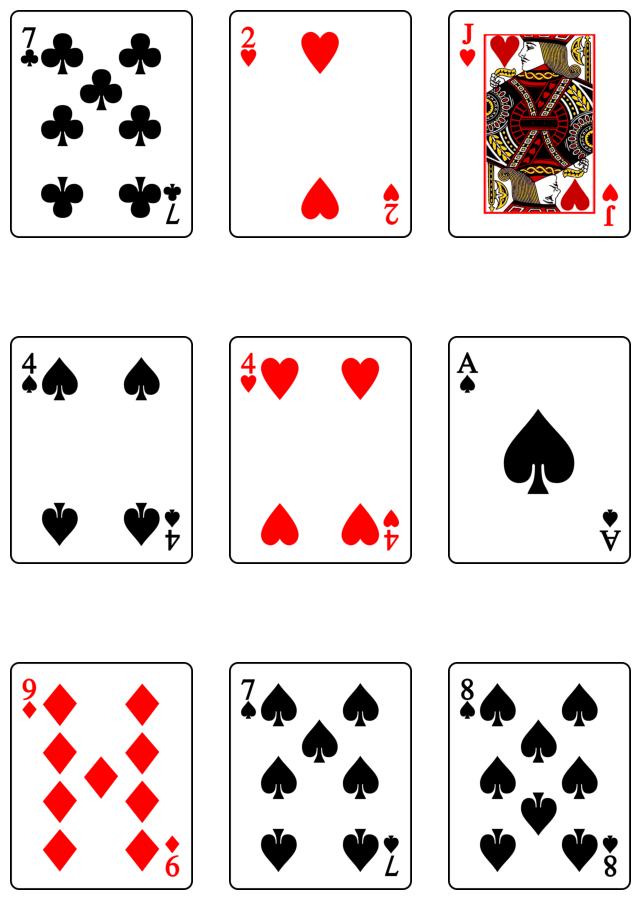

In [31]:
# demo = gr.Interface(
#     flip, 
#     inputs=[gr.inputs.Image(type="pil", label="Input Image", source="webcam"),], 
#     outputs="image",
#     live=True
# )

demo = gr.Interface(
    flip, 
    inputs=[gr.inputs.Image(type="pil", label="Input Image"),], 
    outputs="image",
)

demo.launch(share=True)

In [25]:
import shutil
import os

if os.path.exists(test_path):
    shutil.rmtree(test_path)
if os.path.exists(results_path):
    shutil.rmtree(results_path)

os.mkdir(test_path)
os.mkdir(results_path)

563921995

5C 0.8025321960449219
2H 0.7548098564147949
9H 0.9389421939849854
2H 0.9387189149856567
KS 0.92955082654953
5C 0.910872220993042
3S 0.9062784910202026
10S 0.9042278528213501
QC 0.8269354104995728
10D 0.7865422964096069
QD 0.6802209615707397


divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


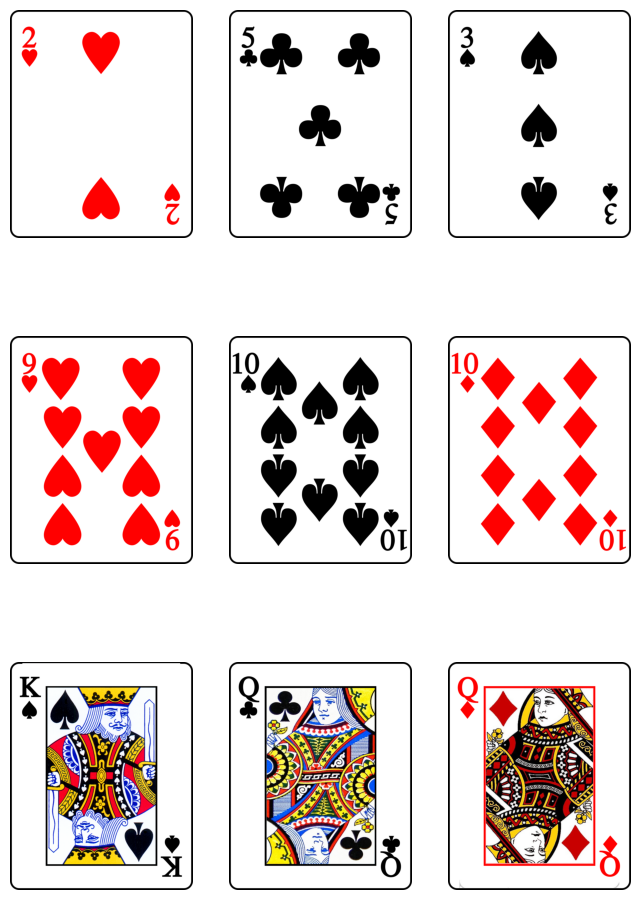

In [34]:
from math import comb
comb(52-9, 9)